# Real Estate Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import folium
import warnings

from sklearn.impute import SimpleImputer as SI
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline as mp
from sklearn.model_selection import train_test_split


%matplotlib inline
sb.set_theme(style = 'white')
warnings.filterwarnings('ignore')

In [2]:
# plot functions
# User defined histogram plot function
def hist_plot(data, x_arg, title, x_label, y_label, bin_size, kde):
    sb.histplot(data = data, x = x_arg, bins = bin_size, kde = kde)
    plt.axvline(data[x_arg].mean(), color = 'red', linestyle = '-', linewidth = 2, label = 'Mean')
    plt.axvline(data[x_arg].median(), color = 'cyan', linestyle = ':', linewidth = 2, label = 'Median')
    plt.title(title, size = 15, weight = 'bold')
    plt.xlabel(x_label, size = 15, weight = 'bold')
    plt.ylabel(y_label, size = 15, weight = 'bold')
    plt.legend()
    
# User defined box plot function    
def box_plot(data, x_arg, y_arg, title, x_label):
    ax = sb.boxplot(data = data, x = x_arg, y = y_arg, color = 'white')#sb.color_palette()[0])
    plt.title(title, size = 15, weight = 'bold')
    plt.xlabel(x_label, size = 15, weight = 'bold')
    plt.setp(ax.lines, color = 'black')
    
def scatter_plot(data, x_arg, y_arg, x_label, y_label, title):
    sb.scatterplot(data = data, x = x_arg, y = y_arg)
    plt.title(title, size = 12, weight = 'bold')
    plt.xlabel(x_label, size = 10, weight = 'bold')
    plt.ylabel(y_label, size = 10, weight = 'bold')
    plt.show()

In [3]:
re_data = pd.read_csv('real_estate.csv')
re_data.head()

,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


## Exploratory Analysis

In [4]:
re_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   transaction_date          414 non-null    float64
 1   house_age                 414 non-null    float64
 2   transit_distance          414 non-null    float64
 3   local_convenience_stores  414 non-null    int64  
 4   latitude                  414 non-null    float64
 5   longitude                 414 non-null    float64
 6   price_per_unit            414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


Form the results, the data set is complete and their are no missing values.

## Estate location

In [5]:
center = [24.98298, 121.54024]
estate_locations = folium.Map(location = center, zoom_start = 13)
for i, j in re_data.iterrows():
    location = [j['latitude'], j['longitude']]
    folium.CircleMarker(location, radius = 2).add_to(estate_locations)
estate_locations

### Price distribution

,count,mean,std,min,25%,50%,75%,max
price_per_unit,414.0,37.980193,13.606488,7.6,27.7,38.45,46.6,117.5


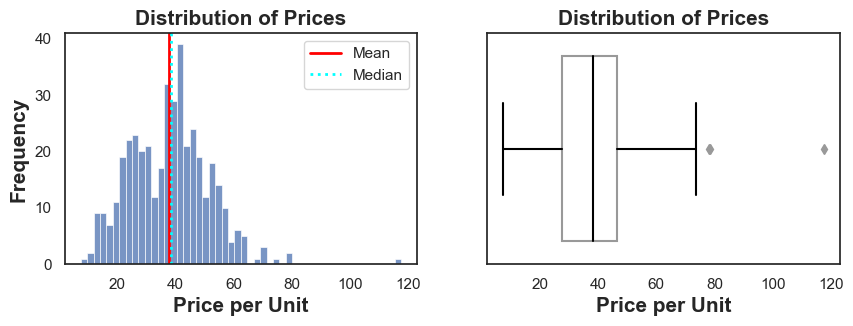

In [6]:
display(re_data[['price_per_unit']].describe().transpose())
plt.figure(figsize = [10, 3])
plt.subplot(1, 2, 1)
hist_plot(re_data, 'price_per_unit', 'Distribution of Prices', 'Price per Unit', 'Frequency', 50, False)
plt.subplot(1, 2, 2)
box_plot(re_data, 'price_per_unit', None, 'Distribution of Prices', 'Price per Unit')

The summary statistics table, histogram and the boxplot, it is evident there are outlier values in the price and these needs to be sieved out.

### Removing outlier values
The lower bound will be defined at 0%, and the upper bound at 99%.

In [ ]:
lower_bound = re_data['price_per_unit'].quantile(0)
upper_bound = re_data['price_per_unit'].quantile(0.99)
mark_bound_price = re_data['price_per_unit'].between(lower_bound, upper_bound)
re_data = re_data[mark_bound_price].reset_index().drop(columns = {'index'})

display(re_data[['price_per_unit']].describe().transpose())
plt.figure(figsize = [10, 3])
plt.subplot(1, 2, 1)
hist_plot(re_data, 'price_per_unit', 'Distribution of Prices', 'Price per Unit', 'Frequency', 50, False)
plt.subplot(1, 2, 2)
box_plot(re_data, 'price_per_unit', None, 'Distribution of Prices', 'Price per Unit')

### Correlation between price and other features in the table

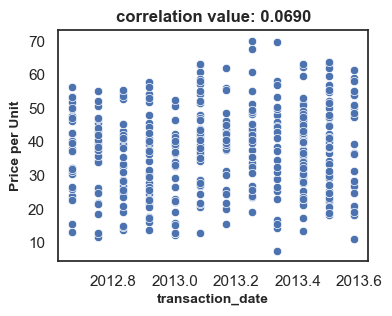

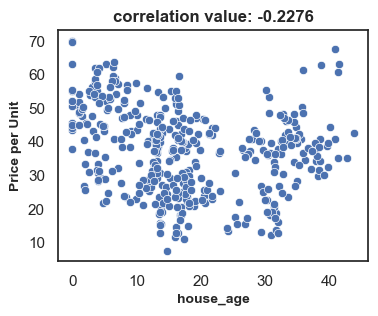

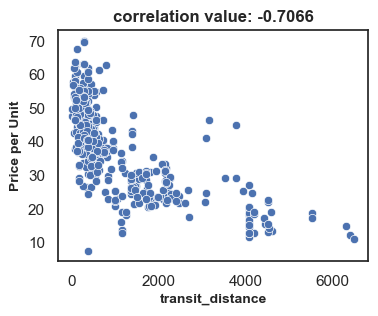

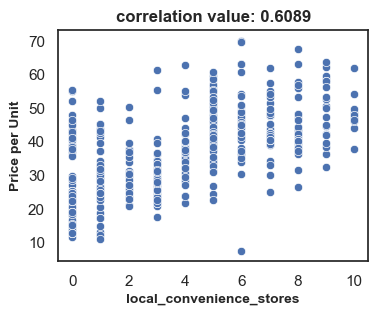

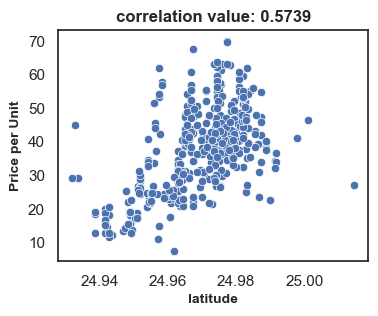

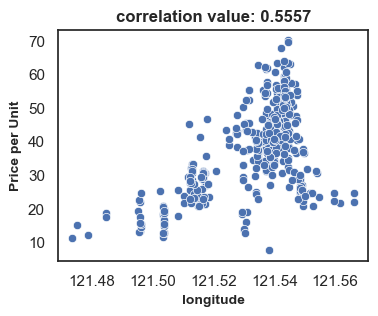

In [8]:
for col in re_data.columns[:-1]:
    plt.figure(figsize = [4, 3])
    correlation = re_data['price_per_unit'].corr(re_data[col])
    scatter_plot(re_data, col, 'price_per_unit', col, 'Price per Unit', f'correlation value: {correlation:.4f}')

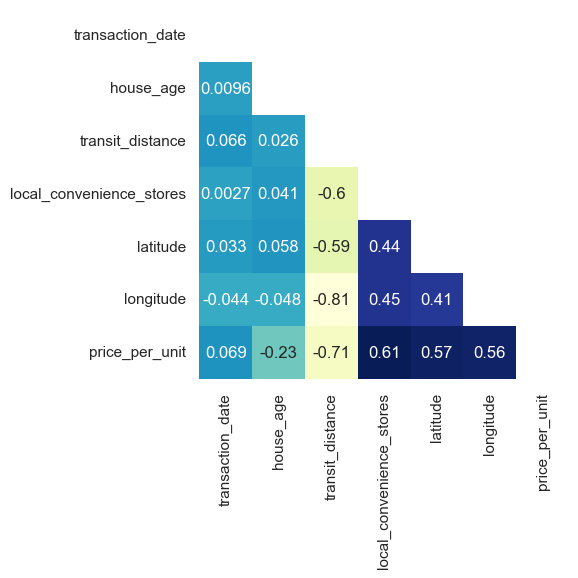

In [9]:
mask = np.triu(np.ones_like(re_data.corr()))
sb.heatmap(re_data.corr(), cmap = 'YlGnBu', annot = True, square = True, mask = mask, cbar = False);

The correlation values and the scatter plots above gives a clear evidence that `house age`, `transit distance`, `local convenience stores`, `latitude` and `longitude` all affect the price. `Transaction date` will be ignored since it has very negligible correlation with the price.

Checking the cardinality of local convenience stores:

In [10]:
print(f"Local convenience stores have {re_data['local_convenience_stores'].nunique()} unique values as listed below:")
display(re_data[['local_convenience_stores']].value_counts().sort_values())

Local convenience stores have 11 unique values as listed below:


local_convenience_stores
10                          10
9                           23
2                           24
8                           30
4                           31
7                           31
6                           35
1                           45
3                           46
0                           67
5                           67
dtype: int64

### Separate labels, features, split and normalize data

In [17]:
target_vector = re_data.columns[-1]
features = re_data.columns[1:-1]
X, y = re_data[features].values, re_data[target_vector].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)
print(f'Training set: {X_train.shape[0]}\nTest set:{X_test.shape[0]}')

Training set: 286
Test set:123


## Build regression model
### Baseline

In [32]:
model = mp(LR())

In [18]:
re_data.head()

,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
